# 图像分类

## 数据集

- 首先设置超参数，批次大小、学习率以及训练轮次。
- 使用`transforms.Compose[]`定义一组变换，将图像转换为张量以及归一化。
- 然后构建训练数据集与测试数据集
- 再使用`torch.utils.data.DataLoader`类对数据集构建一个数据加载器来进行批处理。该加载器可以在训练过程中对数据集采样，并一批次一批次的应用变换。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 16
learning_rate = 0.001
num_epochs = 20

# 数据预处理转换器
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), # 每个通道的均值
        std=(0.2023, 0.1994, 0.2010) # 每个通道的标准差，均值和标准差是根据数据集本身预先确定的
    )
])

# 构建训练集数据，使用transform处理数据集
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
# 构建测试集数据，使用transform处理数据集
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

# 数据批处理
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

# 标签
print(train_set.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## 构建网络

- 构建卷积神经网络类`CNN`，网络结构分为特征提取器(features)和分类器(classifier)。
  - features中包含三个卷积层、三个批归一化层、ReLU激活函数层和最大池化层。
  - classifier包含了两个Dropout层以及全连接层，中间进行了一个ReLU激活函数操作。最后一个全连接层输出为10对应CIFAR-10的10个类别。
- 构建前向传播函数进行数据处理：首先经过卷积层和池化层，然后将特征展平之后经过全连接层输出。
- 进行模型实例化，检测GPU是否可用，如果GPU可用将模型参数移动到GPU上，否则还是在CPU上。 

In [2]:
import torch.nn as nn
# import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 卷积层1，输入通道数3，输出通道数64，卷积核大小3x3，padding=1
            nn.BatchNorm2d(64), # 批归一化层
            nn.ReLU(inplace=True), # 激活函数ReLU
            nn.MaxPool2d(2),  # 最大池化层，池化核大小2x2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 卷积层2，输入通道数64，输出通道数128
            nn.BatchNorm2d(128), # 批归一化层
            nn.ReLU(inplace=True), # 激活函数ReLU
            nn.MaxPool2d(2),  # 最大池化层，池化核大小2x2
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 卷积层3，输入通道数128，输出通道数256
            nn.BatchNorm2d(256), # 批归一化层
            nn.ReLU(inplace=True), # 激活函数ReLU
            nn.MaxPool2d(2),  # 最大池化层，池化核大小2x2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # Dropout层，防止过拟合
            nn.Linear(256*4*4, 1024), # 全连接层1，输入特征数256*4*4=4096，输出特征数1024
            nn.ReLU(inplace=True), # 激活函数ReLU
            nn.Dropout(0.5), # Dropout层，防止过拟合
            nn.Linear(1024, 10), # 全连接层2，输入特征数1024，输出特征数10（CIFAR-10有10个类别）
        )

    def forward(self, x):
        x = self.features(x) # 前向传播，经过卷积层和池化层
        x = x.view(x.size(0), -1) # 将特征图展平，-1表示自动计算维度
        x = self.classifier(x) # 前向传播，经过全连接层
        return x
    
# 实例化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = CNN().to(device)


## 模型训练

### 选择优化器和损失函数
- 使用交叉熵损失函数。
- 优化器使用Adam优化器可以快速收敛。

In [3]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.Adam(net.parameters(), lr=learning_rate) # Adam优化器

### 训练函数
训练过程主要包括前向传播计算输出、计算损失、反向传播计算梯度、参数更新。

In [4]:
def train(epoch):
    net.train() # 设置模型为训练模式
    running_loss = 0.0 # 初始化损失值

    # 遍历训练数据集
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # 将数据移动到GPU上
        optimizer.zero_grad() # 清空梯度(防止梯度累加)
        outputs = net(inputs) # 前向传播(计算模型输出)
        loss = criterion(outputs, targets) # 计算损失值
        loss.backward() # 反向传播(计算梯度)
        optimizer.step() # 更新参数
        running_loss += loss.item() # 累加本批次的损失值
    print(f'Epoch {epoch}: Loss = {running_loss/len(train_loader):.4f}') # 打印当前epoch的平均损失值

### 模型保存与评估函数

该部分包括模型保存函数和模型评估函数。其中模型评估函数会计算并返回每个轮次的准确率和每个类别的精确率。


In [5]:
def save_models(epoch):
    torch.save(net.state_dict(), "cifar10model_{}.model".format(epoch)) # 保存模型
print("Chekcpoint saved")
 

from sklearn.metrics import precision_score
def evaluate():
    net.eval() # 设置模型为评估模式
    correct = 0 # 初始化正确预测的数量
    total = 0 # 初始化总样本数量
    all_preds = [] # 初始化所有预测结果列表
    all_targets = [] # 初始化所有真实标签列表
    
    # 遍历测试数据集
    # 这里使用torch.no_grad()来关闭梯度计算，节省内存和计算资源
    with torch.no_grad():
        for inputs, targets in test_loader: # 从test_loader中获取数据
            inputs, targets = inputs.to(device), targets.to(device) # 将数据移动到GPU上
            outputs = net(inputs) # 前向传播(计算模型输出)
            _, predicted = outputs.max(1) # 获取预测结果，max(1)表示按行取最大值，返回值是最大值和索引
            total += targets.size(0) # 累加本批次样本数
            correct += (predicted == targets).sum().item() # 累加正确预测的数量
            all_preds.extend(predicted.cpu().numpy()) # 将预测结果从GPU移动到CPU并转换为numpy数组
            all_targets.extend(targets.cpu().numpy()) # 将真实标签从GPU移动到CPU并转换为numpy数组
    acc = correct / total # 计算准确率
    precisions = precision_score(all_targets, all_preds, average=None) # 计算每类的精确率
    print(f'Test Accuracy: {acc:.4f}')
    for i, p in enumerate(precisions):
        print(f'Class {i} Precision: {p:.4f}')
    return acc, precisions # 返回整体准确率和每类的精确率

Chekcpoint saved


## 主流程

该流程包括训练神经网络若干轮次、每轮次评估模型性能、记录准确率和每一类的精确率、保存最佳模型以及结果可视化。

Epoch 1: Loss = 1.5189
Test Accuracy: 0.6088
Class 0 Precision: 0.7103
Class 1 Precision: 0.7824
Class 2 Precision: 0.3527
Class 3 Precision: 0.4961
Class 4 Precision: 0.5890
Class 5 Precision: 0.5668
Class 6 Precision: 0.6037
Class 7 Precision: 0.7592
Class 8 Precision: 0.6805
Class 9 Precision: 0.6602
Epoch 2: Loss = 1.1722
Test Accuracy: 0.6694
Class 0 Precision: 0.8355
Class 1 Precision: 0.7723
Class 2 Precision: 0.5847
Class 3 Precision: 0.5195
Class 4 Precision: 0.5200
Class 5 Precision: 0.6706
Class 6 Precision: 0.7622
Class 7 Precision: 0.5776
Class 8 Precision: 0.7563
Class 9 Precision: 0.8256
Epoch 3: Loss = 1.0053
Test Accuracy: 0.7043
Class 0 Precision: 0.7801
Class 1 Precision: 0.9089
Class 2 Precision: 0.6538
Class 3 Precision: 0.4272
Class 4 Precision: 0.7035
Class 5 Precision: 0.7917
Class 6 Precision: 0.6889
Class 7 Precision: 0.8020
Class 8 Precision: 0.8091
Class 9 Precision: 0.7088
Epoch 4: Loss = 0.8988
Test Accuracy: 0.7548
Class 0 Precision: 0.7805
Class 1 Precis

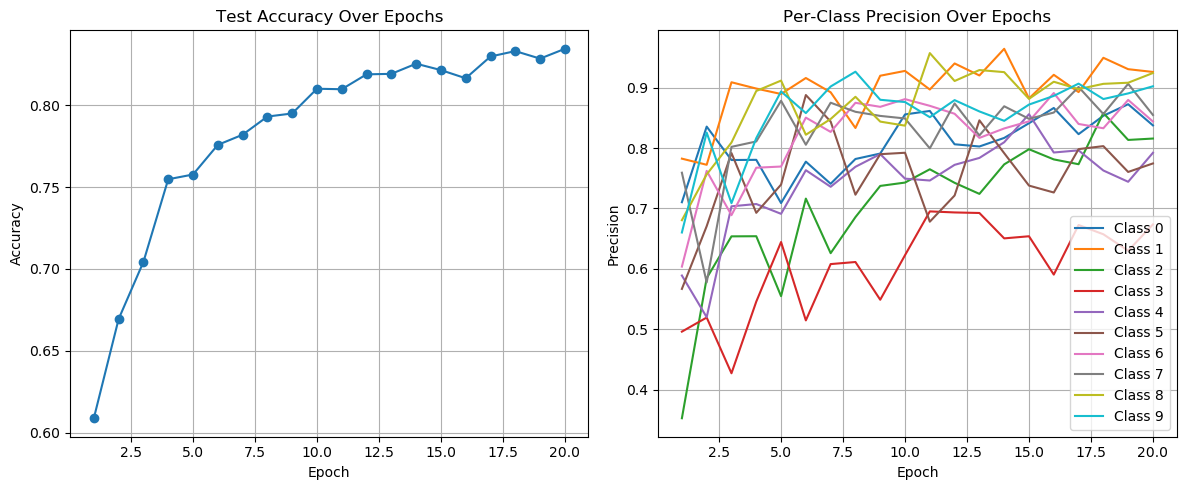

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 记录每轮的 accuracy 和每类 precision
acc_list = [] # 存放每一轮的准确率
precision_list = [] # 存放每一轮的每个类别的精确率

if __name__ == '__main__':
    best_acc = 0.0 # 初始化最佳准确率为0.0
    # 训练和评估模型
    for epoch in range(1, num_epochs+1): # 遍历每个epoch
        train(epoch) # 执行训练函数
        acc, precisions = evaluate() # 执行评估函数返回准确率和每类精确率
        acc_list.append(acc) # 保存每一轮的准确率
        precision_list.append(precisions) # 保存每一轮的每个类别的精确率
        # 保存最佳模型
        if acc > best_acc:
            best_acc = acc
            torch.save(net.state_dict(), 'best_cifar10_cnn.pth')
    print(f'Best Test Accuracy: {best_acc:.4f}')

    # 绘制准确率和每一类精确率曲线
    epochs = list(range(1, num_epochs+1))

    plt.figure(figsize=(12, 5)) 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_list, marker='o')
    plt.title('Test Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # 绘制每一类精确率曲线
    plt.subplot(1, 2, 2)
    precision_array = np.array(precision_list)  # shape: [epoch, class]
    for cls_idx in range(10):
        plt.plot(epochs, precision_array[:, cls_idx], label=f'Class {cls_idx}')
    plt.title('Per-Class Precision Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
